In [164]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
from scipy import stats
import math 
import sympy as sp
from IPython.core.display import Latex
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import sys

In [210]:
sys.path.append('..\External_Functions')
from ExternalFunctions import Chi2Regression, nice_string_output, UnbinnedLH, BinnedLH
from ExternalFunctions import add_text_to_ax 

In [166]:
sys.path.append('..\My_Functions')
from My_Functions import *


Problem 1

In [167]:
#First game requires a least 1 six in 4 throws
#The probability is
print(stats.binom.sf(1, 4, 1/6))

0.13194444444444448


In [168]:
stats.binom.cdf(1, 2, 1/2)

0.75

In [169]:
#second game requires a pair of sixes in 24 throws of 2 dice
#The probability is
print(stats.binom.sf(1, 24, 1/36))

0.1426522483349511


In [170]:
#1.2
#Daily average 
lambd = 18.9 

#The distribution is Poisson
#Is 42 events in 1 day significant?
print(stats.poisson.sf(42, lambd), 'yes!!')

1.3718502458083341e-06 yes!!


In [171]:
#1.3 
mean = 1.68
std = 0.06

#What fraction is taller than 1.85
print(stats.norm.sf(1.85, mean, std))

0.002303266131695864


In [172]:
#What is the mean of the tallest 20%
#We do this numerically 
r = np.random
r.seed(42)
x = r.normal(mean, std, 100000)
print(np.mean(x[x > np.percentile(x, 80)]))

1.7641747813481898


Problem 2

In [173]:
L, r = sp.symbols('L r')
eq = L/(sp.pi * r**2)
sigma_L, sigma_r = sp.symbols('sigma_L sigma_r')
prop = Error_Prop(eq, (L, r), (sigma_L, sigma_r), (1.68, 0.06), (0.06, 0.06), [[1, 0], [0, 1]])
display(prop.get_propEq())
display(prop.derivatives[0]/prop.derivatives[1])

0.12*sqrt(L**2*sigma_r**2/(pi**2*r**6) + 0.25*sigma_L**2/(pi**2*r**4))

-r/(2*L)

In [174]:
#2.2
#The data
speed = np.array([3.61, 2.00, 3.9, 2.23, 2.32, 2.48, 2.43, 3.86, 4.43, 3.78])
#Average speed with uncertainty
mean = np.mean(speed)
uncert = np.std(speed, ddof=1)/np.sqrt(len(speed))
print(mean, '+/-', uncert)

3.104 +/- 0.28121640540101256


In [175]:
#mass of the bullet with uncertainty
mass = 8.4
sigma_mass = 0.5

m, v = sp.symbols('m v')
eq = (1/2) * m * v**2
sigma_m, sigma_v = sp.symbols('sigma_m sigma_v')
prop = Error_Prop(eq, (m, v), (sigma_m, sigma_v), (mass, mean), (sigma_mass, uncert), [[1, 0], [0, 1]])
display(prop.get_propEq())
print(prop.get_error())
print(prop.get_contributions())
print(mass*mean**2/2)

0.281216405401013*sqrt(m**2*sigma_v**2*v**2 + 0.790312247100081*sigma_m**2*v**4)

7.717825548416559
[5.8018549596160005, 53.762976236175355]
40.466227200000006


In [176]:
#For them to contribute equally we need 10 times the measurements of speed
prop_2 = Error_Prop(eq, (m, v), (sigma_m, sigma_v), (mass, mean), (sigma_mass, uncert/np.sqrt(10)), [[1, 0], [0, 1]])
print(prop_2.get_error())
print(prop_2.get_contributions())
print('meaning we need 100 measurements of speed')

3.3433744306065294
[5.8018549596160005, 5.376297623617535]
meaning we need 100 measurements of speed


Problem 3

In [177]:

def normalization_constant(func, var, norm_const, range):
    integral = sp.integrate(func, (var, *range))
    val_const = norm_const/integral
    return val_const, integral


In [218]:
#f(x) = C * x**(-0.9), x in [0.005, 1]

#First we determine C so f(x) is normalized
#We integrate f(x) from 0.005 to 1


C, x = sp.symbols('C x')
eq = C * x**(-0.9)
integral = sp.integrate(eq, (x, 0.005, 1))
print('the integral equals', integral)
val_C = C/integral
print('Therefore the constant C should equal',val_C)



the integral equals 4.11295981347525*C
Therefore the constant C should equal 0.243133909726934


We can use both methods, since it is bound in both x and y, and the integral is invertible. When the range is [0, 1], we can no longer use accept reject, since it is no longer bound in y. We can use the inverse transform method, since it is still invertible and the integral is finite.

In [179]:
def anal_monte_carlo(f, var, range, N_points, random):
    F = sp.integrate(f, var)
    F_func = sp.lambdify(x, F)
    u = sp.symbols('u')
    inverse = sp.solve(F - u, var)[0]
    inverse_func = sp.lambdify(u, inverse)
    us = random.uniform(F_func(range[0]), F_func(range[1]), N_points)
    return inverse_func(us)
    

In [219]:
#Produce 10000 random numbers from the distribution
#Here I assume it is in the range [0.005, 1], since that is the original range
#We use the inverse transform method
F = sp.integrate(val_C * x**(-0.9))
u = sp.symbols('u')
display(F)
F_invers = sp.solve(F - u , x)
display(F_invers)
F_invers = sp.lambdify(u, F_invers[0])
display(F_invers)
r = np.random
r.seed(69)
f = sp.lambdify(x, F)
us = r.uniform(f(0.005), f(1), 10000)
xs = F_invers(us)

xs = anal_monte_carlo(val_C * x**(-0.9), x, (0.005, 1), 10000, r)

2.43133909726934*x**0.1

[0.000138530263933902*u**10]

<function _lambdifygenerated(u)>

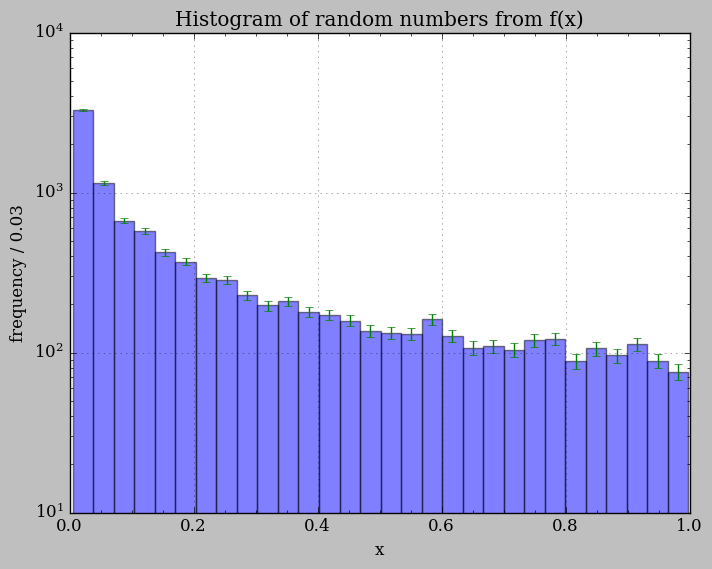

In [220]:
plot_pref()
counts, binedges, bincenters, binwidth = create_histogram(xs, 30)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(xs, bins=30, label='Histogram', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel(f'frequency / {binwidth:.2f}')
ax.set_title('Histogram of random numbers from f(x)')
ax.errorbar(bincenters, counts, yerr=np.sqrt(counts), fmt='none', label='Poisson error')
ax.set_yscale('log')

In [234]:
def fit_pdf(x, C):
    return C * x**(-0.9)

#We fit the histogram with the pdf
chi2 = Chi2Regression(fit_pdf, bincenters, counts, np.sqrt(counts))
minuit = Minuit(chi2, C=100)
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 179.2                      │              Nfcn = 11               │
│ EDM = 1.49e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ C    │   85.3    │    0.9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────┐
│   │    C │
├───┼──────┤
│ C │ 0.74 │
└───┴──────┘

In [225]:
ullh = UnbinnedLH(fit_pdf, xs, extended=True)
minuit_ullh = Minuit(ullh, C=100)
minuit_ullh.errordef = 0.5
minuit_ullh.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -8.983e+04                 │              Nfcn = 35               │
│ EDM = 4.12e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ C    │  2.431e3  │  0.024e3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────┐
│   │   C │
├───┼─────┤
│ C │ 591 │
└───┴─────┘

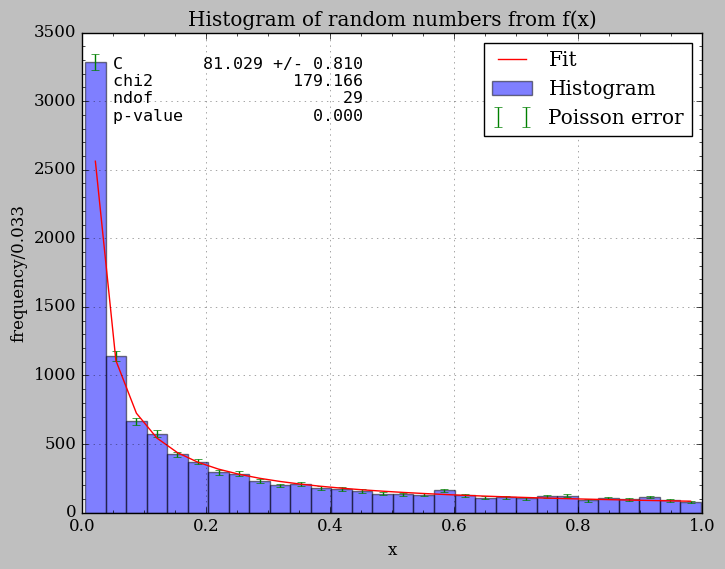

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(xs, bins=30, label='Histogram', alpha=0.5)
ax.errorbar(bincenters, counts, yerr=np.sqrt(counts), fmt='none', label='Poisson error')
ax.set_xlabel('x')
ax.set_ylabel(f'frequency/{binwidth:.3f}')
ax.set_title('Histogram of random numbers from f(x)')
#ax.set_yscale('log')
ax.plot(bincenters, fit_pdf(bincenters, *minuit_ullh.values)/30, label='Fit')
ax.legend()

chi2_val, ndof, p_value = evaluate_chi2(minuit, len(counts))

d = {
    'C': [minuit_ullh.values['C']/30, minuit_ullh.errors['C']/30],
    'chi2': chi2_val,
    'ndof': ndof,
    'p-value': p_value
}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=12)

In [240]:
#We take the sum of 50 random numbers from the distribution 1000 times
u_2 = r.uniform(f(0.005), f(1), (1000, 50))
x_2 = F_invers(u_2)
t = np.sum(x_2, axis=1)

c:\Users\Jonathan Krebs\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2086: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
c:\Users\Jonathan Krebs\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


KstestResult(statistic=0.020185239719876916, pvalue=0.8020231515802307)


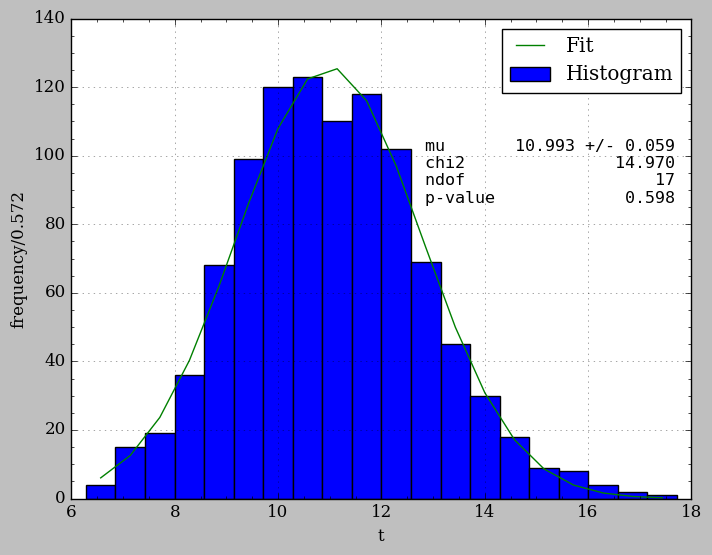

In [245]:
#We then plot the histogram of the sums
counts, binedges, bincenters, binwidth = create_histogram(t, 20)

chi2_gauss = Chi2Regression(gauss, bincenters, counts, np.sqrt(counts))


minuit_gauss = Minuit(chi2_gauss, mu=11, sigma=5, N= 1)
minuit_gauss.migrad();
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(t, bins=20, label='Histogram')
ax.plot(bincenters, gauss(bincenters, *minuit_gauss.values), label='Fit')
ax.set_xlabel('t')
ax.set_ylabel(f'frequency/{binwidth:.3f}')
ax.legend()

chi2_val, ndof, p_value = evaluate_chi2(minuit_gauss, len(counts))

d = {
    'mu': [minuit_gauss.values['mu'], minuit_gauss.errors['mu']],
    'chi2': chi2_val,
    'ndof': ndof,
    'p-value': p_value
}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.57, 0.75, text, ax, fontsize=12)
print(stats.ks_1samp(t, stats.norm.cdf, args=( minuit_gauss.values['mu'], minuit_gauss.values['sigma'])))

In [186]:
#What would we expect the mean of t to be?
x_mean = sp.integrate(val_C * x**(-0.9) * x, (x, 0.005, 1))
print('The mean of x is', x_mean)
t_mean = 50 * x_mean
print('The mean of t should be', t_mean)

The mean of x is 0.220380218343909
The mean of t should be 11.0190109171954


In [187]:
#t-test to determine if they are consistent
ttest, p = stats.ttest_1samp(t, 11.0190109171954)

print(ttest, p)
print('The p-value is', p, 'which is large, meaning the 2 values are consistent')


0.07429704316178784 0.9407889036018274
The p-value is 0.9407889036018274 which is large, meaning the 2 values are consistent


Problem 4

In [188]:
#We work with the FisherSyndrome data
FS_data = np.genfromtxt('data_FisherSyndrome.txt', delimiter='', skip_header=0)

Healthy = FS_data[ FS_data[:,0] == 0]
Sick = FS_data[FS_data[:,0] == 1]


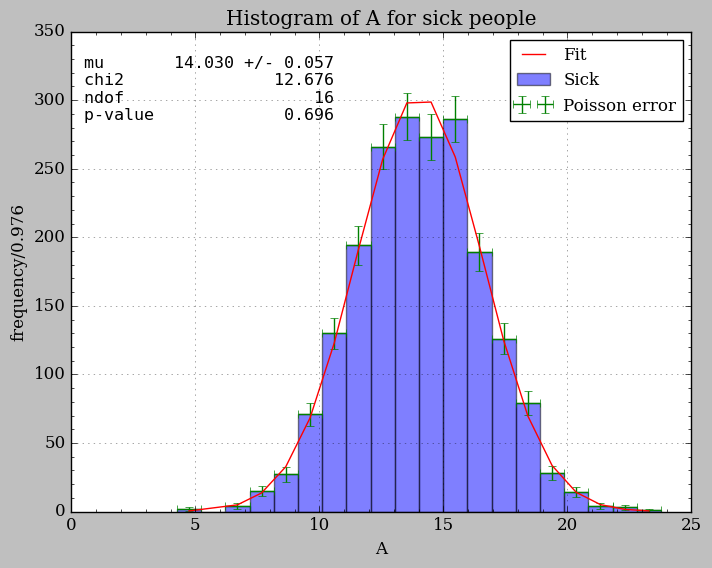

In [189]:
count_A, binedges, bincenters, binwidth = create_histogram(Sick[:,2], 20)

mask_sick = count_A > 0
count_A = count_A[mask_sick]
bincenters = bincenters[mask_sick]


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(Sick[:,2], bins=20, label='Sick', alpha = 0.5);
ax.errorbar(bincenters, count_A, xerr = binwidth/2, yerr=np.sqrt(count_A), fmt='none', label='Poisson error')
ax.set_xlabel('A')
ax.set_ylabel(f'frequency/{binwidth:.3f}')
ax.set_title('Histogram of A for sick people')

chi2_sick = Chi2Regression(gauss, bincenters, count_A, np.sqrt(count_A))
minuit_sick = Minuit(chi2_sick, mu=14, sigma=2, N= 1000)
minuit_sick.migrad();

ax.plot(bincenters, gauss(bincenters, *minuit_sick.values), label='Fit')
ax.legend( loc='upper right', fontsize=12)

chi2_val, ndof, p_value = evaluate_chi2(minuit_sick, len(count_A))

d = {
    'mu': [minuit_sick.values['mu'], minuit_sick.errors['mu']],
    'chi2': chi2_val,
    'ndof': ndof,
    'p-value': p_value
}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=12)


The covariance matrix is [[37.38835956 -1.35122639]
 [-1.35122639  0.32392882]]
The correlation coefficient is -0.388271145294667


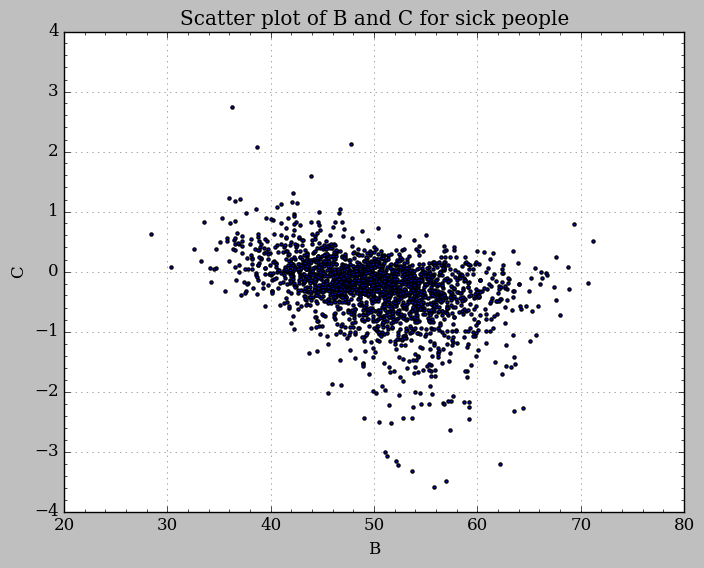

In [230]:
#What is the linear correlation between B and C for Sick?
sick_B = Sick[:,3]
sick_C = Sick[:,4]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(sick_B, sick_C, label='Sick', marker = '.')
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_title('Scatter plot of B and C for sick people')

#Variance matrix
cov = np.cov(sick_B, sick_C)
print('The covariance matrix is', cov)
#the correlation coefficient is
corr = cov[0,1]/np.sqrt(cov[0,0]*cov[1,1])
print('The correlation coefficient is', corr)

In [191]:
healthy_A = Healthy[:,2]
healthy_B = Healthy[:,3]
healthy_C = Healthy[:,4]

sick_A = Sick[:,2]

Text(0.5, 1.0, 'Scatter plot of A and C')

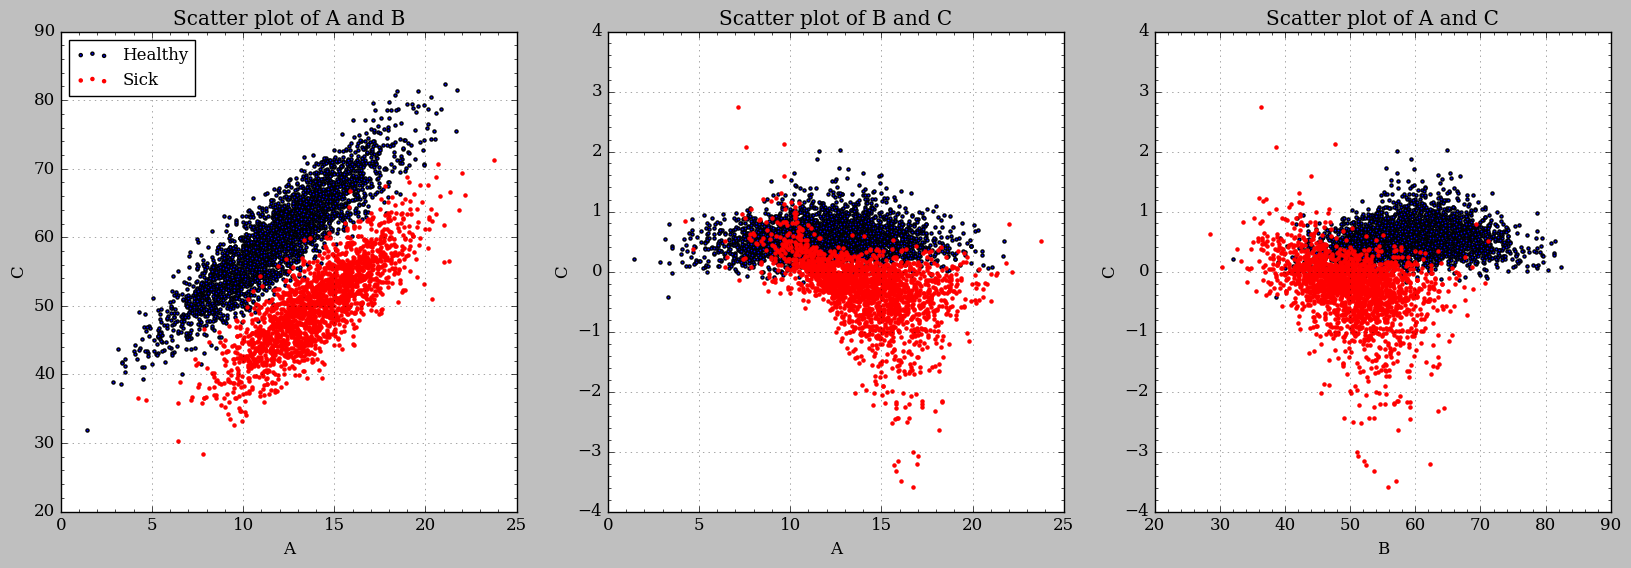

In [192]:
#Scatter plot for each combination of variables
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].scatter(healthy_A, healthy_B, label='Healthy', marker = '.')
ax[0].scatter(sick_A, sick_B, label='Sick', marker = '.', color = 'red')
ax[0].set_xlabel('A')
ax[0].set_ylabel('C')
ax[0].set_title('Scatter plot of A and B')
ax[0].legend(fontsize = 12, loc = 'upper left')

ax[1].scatter(healthy_A, healthy_C, label='Healthy', marker = '.')
ax[1].scatter(sick_A, sick_C, label='Sick', marker = '.', color = 'red')
ax[1].set_xlabel('A')
ax[1].set_ylabel('C')
ax[1].set_title('Scatter plot of B and C')

ax[2].scatter(healthy_B, healthy_C, label='Healthy', marker = '.')
ax[2].scatter(sick_B, sick_C, label='Sick', marker = '.', color = 'red')
ax[2].set_xlabel('B')
ax[2].set_ylabel('C')
ax[2].set_title('Scatter plot of A and C')

Text(0, 0.5, 'C')

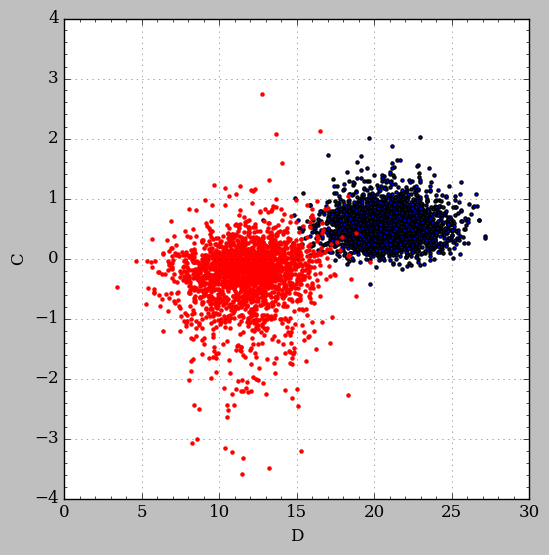

In [193]:
#We use fisher to seperate the two distributions using A and B
#print(Healthy[:,2:4].shape)
healthy_D, sick_D = fisher(Healthy[:, 2:4], Sick[:, 2:4])

#We plot the distributions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(healthy_D, healthy_C, label='Healthy', marker = '.')
ax.scatter(sick_D, sick_C, label='Sick', marker = '.', color = 'red')
ax.set_xlabel('D')
ax.set_ylabel('C')


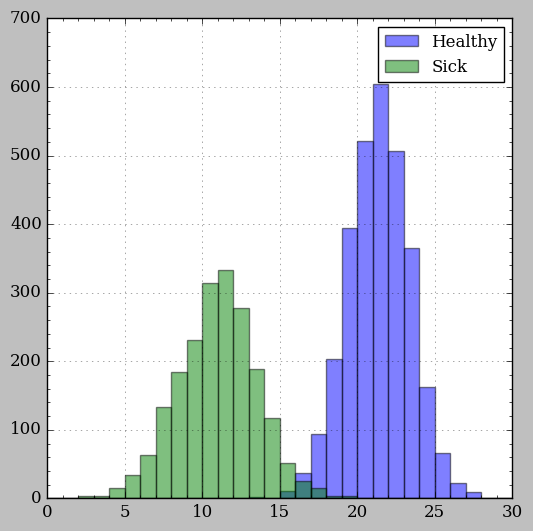

In [194]:
healthy_E, sick_E = fisher(np.array([healthy_D, healthy_C]).T, np.array([sick_D, sick_C]).T)

#We plot the distributions
bin_E = np.linspace(0, 30, 31)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(healthy_E, bins=bin_E, label='Healthy', alpha = 0.5)
ax.hist(sick_E, bins=bin_E, label='Sick', alpha = 0.5)
ax.legend(fontsize = 12)

In [195]:
def ROC_curve(positive, negative, range, above = True):
    true_positive = []
    false_positive = []
    if above:
        for i in range:
            true_positive.append((positive > i).sum()/len(positive))
            false_positive.append((negative > i).sum()/len(negative))
    else:
        for i in range:
            true_positive.append((positive < i).sum()/len(positive))
            false_positive.append((negative < i).sum()/len(negative))
    return np.array(true_positive), np.array(false_positive)

In [196]:
def ROC_Fit(fit_positive, fit_negative):
    cumulative_positive = np.cumsum(fit_positive)
    cumulative_negative = np.cumsum(fit_negative)
    return cumulative_positive/cumulative_positive[-1], cumulative_negative/cumulative_negative[-1]

The cutoff is 17.68768768768769
The TPR is 0.9955 beta = 0.0044999999999999485
The FPR is 0.03666666666666667 = alpha


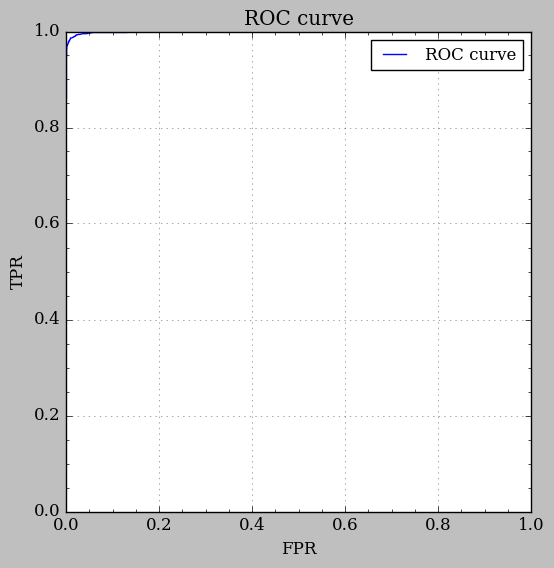

In [197]:
#In order to find the best cut, we need to find the best separation between the two distributions
#We make a ROC curve
cutoffs = np.linspace(0, 30, 1000)
TPR = []
FPR = []
for cutoff in cutoffs:
    TP = np.sum(sick_E < cutoff)
    FP = np.sum(healthy_E < cutoff)
    TPR.append(TP/len(sick_E))
    FPR.append(FP/len(healthy_E))


TPR, FPR = ROC_curve(sick_E, healthy_E, cutoffs, above = False)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(FPR, TPR, label='ROC curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC curve')
#ax.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))
ax.legend(fontsize = 12)

#We chose the cutoff for 0.99 TPR
cutoff_i = np.where(np.array(TPR) > 0.995)[0][0]
cutoff = cutoffs[cutoff_i]
TPR_cut = TPR[cutoff_i]
FPR_cut = FPR[cutoff_i]
print('The cutoff is', cutoff)
print('The TPR is', TPR_cut, 'beta =', 1-TPR_cut)
print('The FPR is', FPR_cut, '= alpha')
fig.savefig('figures/ROC_curve.png')

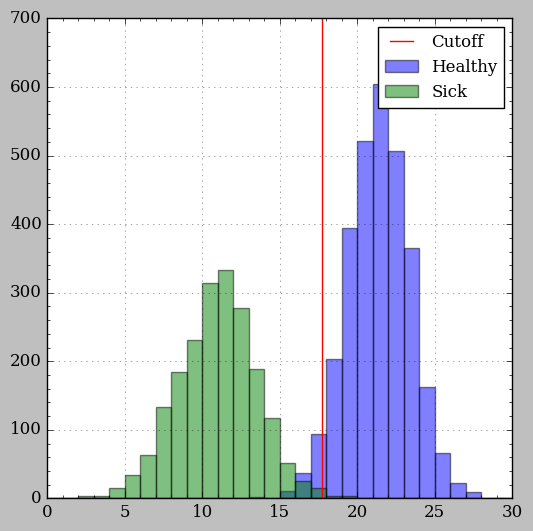

In [198]:
bin_E = np.linspace(0 ,30, 31)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(healthy_E, bins=bin_E, label='Healthy', alpha = 0.5)
ax.hist(sick_E, bins=bin_E, label='Sick', alpha = 0.5)
ax.axvline(x=cutoff, color = 'red', label = 'Cutoff')
ax.legend(fontsize = 12)

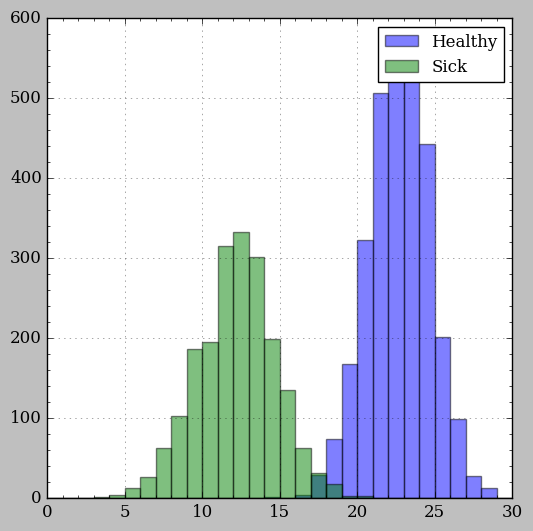

In [199]:
sick_F, healthy_F = fisher(np.array([sick_A, sick_B, sick_C]).T, np.array([healthy_A, healthy_B, healthy_C]).T)


#We plot the distributions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
bin_F = np.linspace(0, 30, 31)
ax.hist(-1*healthy_F, bins=bin_F, label='Healthy', alpha = 0.5)
ax.hist(-1*sick_F, bins=bin_F, label='Sick', alpha = 0.5)
ax.legend(fontsize = 12)



Problem 5

In [200]:
data = np.genfromtxt('data_LukeLightninglights.txt', delimiter = '')

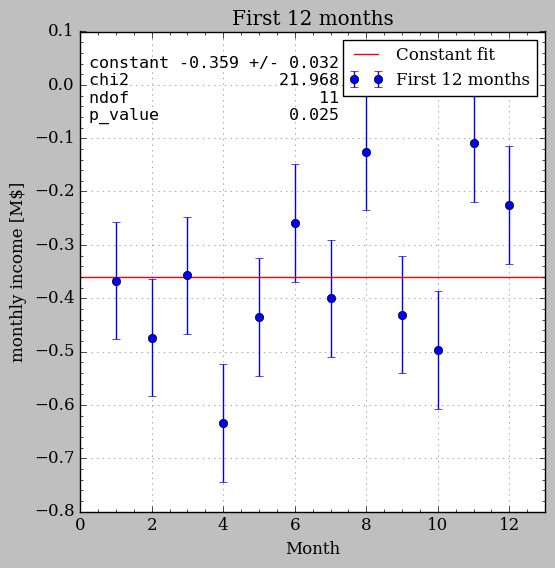

In [201]:
#We check whether the first 12 months are constant 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
def const(x, a):
    return a

chi2_const = Chi2Regression(const, data[:12,0], data[:12,2], data[:12,3])
minuit_const = Minuit(chi2_const,  a = 0)
minuit_const.migrad()

ax.errorbar(data[:12,0], data[:12,2], yerr = data[:12, 3], fmt = 'o', label='First 12 months')
ax.set(xlim = (0, 13))
ax.axhline(y=minuit_const.values['a'], color = 'red', label = 'Constant fit')

ax.set_xlabel('Month')
ax.set_ylabel('monthly income [M$]')
ax.set_title('First 12 months')
ax.legend(fontsize = 12)

chi2, ndof, p_value = evaluate_chi2(minuit_const, len(data[:12,0]))

d = {
    'constant': [minuit_const.values['a'], minuit_const.errors['a']],
    'chi2': chi2, 'ndof': ndof, 'p_value': p_value
    }
text = nice_string_output(d, extra_spacing=1, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=12)
#We cant reject the hypothesis that the first 12 months are constant

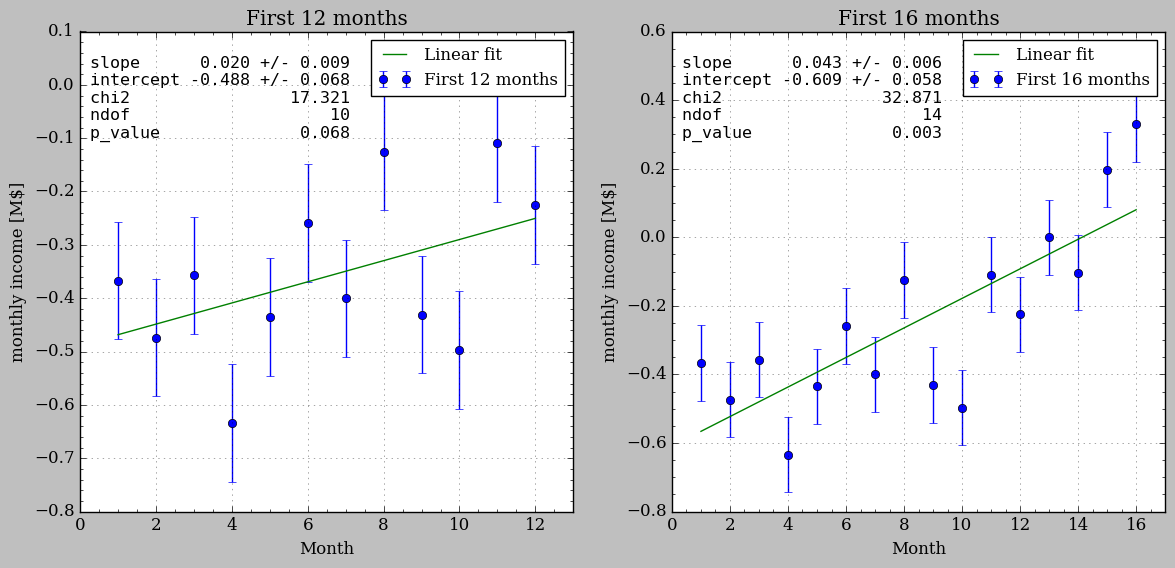

In [202]:
n = 16
chi2_lin1 = Chi2Regression(linear, data[:12,0], data[:12,2], data[:12,3])
minuit_lin1 = Minuit(chi2_lin1,  a = 0, b = 0)
minuit_lin1.migrad()
chi2_lin2 = Chi2Regression(linear, data[:n,0], data[:n,2], data[:n,3])
minuit_lin2 = Minuit(chi2_lin2,  a = 0, b = 0)
minuit_lin2.migrad()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].errorbar(data[:12,0], data[:12,2], yerr = data[:12, 3], fmt = 'o', label='First 12 months')
ax[0].set(xlim = (0, 13))
ax[0].plot(data[:12,0], linear(data[:12,0], minuit_lin1.values['a'], minuit_lin1.values['b']), color = 'green', label = 'Linear fit')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('monthly income [M$]')
ax[0].set_title('First 12 months')
ax[0].legend(fontsize = 12)
chi2, ndof, p_value = evaluate_chi2(minuit_lin1, len(data[:12,0]))

d = {
    'slope': [minuit_lin1.values['a'], minuit_lin1.errors['a']],
    'intercept': [minuit_lin1.values['b'], minuit_lin1.errors['b']],
    'chi2': chi2, 'ndof': ndof, 'p_value': p_value
    }
text = nice_string_output(d, extra_spacing=1, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax[0], fontsize=12)


ax[1].errorbar(data[:n,0], data[:n,2], yerr = data[:n, 3], fmt = 'o', label=f'First {n} months')
ax[1].set(xlim = (0, n+1))
ax[1].plot(data[:n,0], linear(data[:n,0], minuit_lin2.values['a'], minuit_lin2.values['b']), color = 'green', label = 'Linear fit')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('monthly income [M$]')
ax[1].set_title(f'First {n} months')
ax[1].legend(fontsize = 12)

chi2, ndof, p_value = evaluate_chi2(minuit_lin2,n)

d = {
    'slope': [minuit_lin2.values['a'], minuit_lin2.errors['a']],
    'intercept': [minuit_lin2.values['b'], minuit_lin2.errors['b']],
    'chi2': chi2, 'ndof': ndof, 'p_value': p_value
    }
text = nice_string_output(d, extra_spacing=1, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax[1], fontsize=12)



In [203]:
def lin_shift(x, a, b, c):
    if x <= 31:
        return a*x+b
    else:
        return a*x+b+c

lin_shift_vec = np.vectorize(lin_shift)

the change in income is -0.88 +/- 0.13 M$


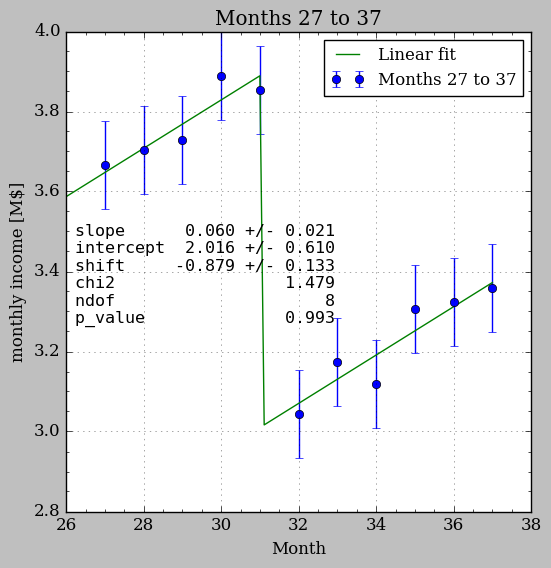

In [204]:
#We look around the 31st month 
low = 26
high = 37

chi2_shift = Chi2Regression(lin_shift, data[low:high,0], data[low:high,2], data[low:high,3])
minuit_shift = Minuit(chi2_shift, a = 0.2, b = 0, c = -4)
minuit_shift.migrad()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.errorbar(data[low:high,0], data[low:high,2], yerr = data[low:high, 3], fmt = 'o', label=f'Months {low+1} to {high}')
xs = np.linspace(low, high, 100)
ax.plot(xs, lin_shift_vec(xs, *minuit_shift.values[:]), color = 'green', label = 'Linear fit')
ax.set(xlim = (low, high+1))
ax.set_xlabel('Month')
ax.set_ylabel('monthly income [M$]')
ax.set_title(f'Months {low+1} to {high}')
ax.legend(fontsize = 12)

chi2, ndof, p_value = evaluate_chi2(minuit_shift, high-low)
d = {
    'slope': [minuit_shift.values['a'], minuit_shift.errors['a']],
    'intercept': [minuit_shift.values['b'], minuit_shift.errors['b']],
    'shift': [minuit_shift.values['c'], minuit_shift.errors['c']],
    'chi2': chi2, 'ndof': ndof, 'p_value': p_value
    }
text = nice_string_output(d, extra_spacing=1, decimals=3)
add_text_to_ax(0.02, 0.6, text, ax, fontsize=12)
print('the change in income is {:.2f} +/- {:.2f} M$'.format(minuit_shift.values['c'], minuit_shift.errors['c']))

In [205]:
#Define logistic growth function
def logistic_shift(x, L, k, x_0, c_1, c_2):
    if x <= 31:
        return L/(1 + np.exp(-k*(x-x_0))) + c_1
    else :
        return (L)/(1 + np.exp(-k*(x-x_0))) + c_2
log_vec = np.vectorize(logistic_shift)

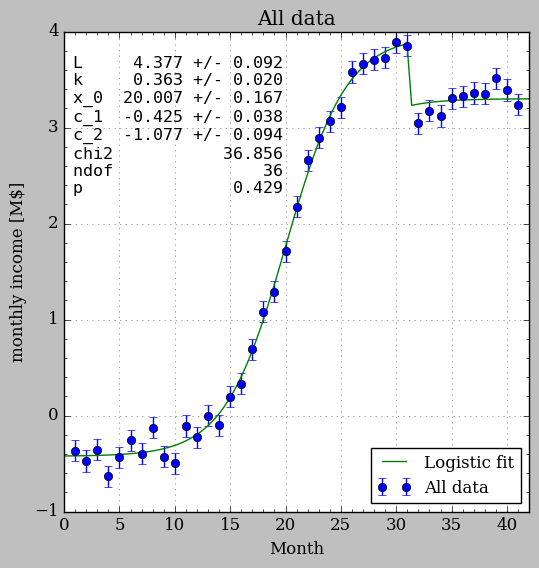

In [206]:
#We now fit the whole data set
x = data[:,0]
y = data[:,2]
yerr = data[:,3]

chi2_log = Chi2Regression(logistic_shift, x, y, yerr)
minuit_log = Minuit(chi2_log, L = 4, k = 2, x_0 = 10, c_1 = -0.2, c_2 =-0.8)
minuit_log.migrad();

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.errorbar(x, y, yerr = yerr, fmt = 'o', label=f'All data')
X = np.linspace(0, 42, 100)
Y = log_vec(X, *minuit_log.values)
ax.plot(X, Y, color = 'green', label = 'Logistic fit')
ax.set(xlim = (0, 42))
ax.set_xlabel('Month')
ax.set_ylabel('monthly income [M$]')
ax.set_title(f'All data')
ax.legend(fontsize = 12, loc = 'lower right')

chi2, ndof, p_value = evaluate_chi2(minuit_log, len(x))
d = {
    'L': [minuit_log.values['L'], minuit_log.errors['L']],
    'k': [minuit_log.values['k'], minuit_log.errors['k']],
    'x_0': [minuit_log.values['x_0'], minuit_log.errors['x_0']],
    'c_1': [minuit_log.values['c_1'], minuit_log.errors['c_1']],
    'c_2': [minuit_log.values['c_2'], minuit_log.errors['c_2']],
    'chi2': chi2, 'ndof': ndof, 'p': p_value
    }

text = nice_string_output(d, extra_spacing=1, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=12)


In [207]:
#5.2
residuals = np.genfromtxt('data_TimingResiduals.txt', delimiter = ',')


In [208]:
#t test to determine if consistent with 0
t, p = stats.ttest_1samp(residuals, 0)
print('t = {:.2f}, p = {:.2f}'.format(t, p))


t = 0.07, p = 0.94


Text(0.5, 1.0, 'Residuals of the timing measurements')

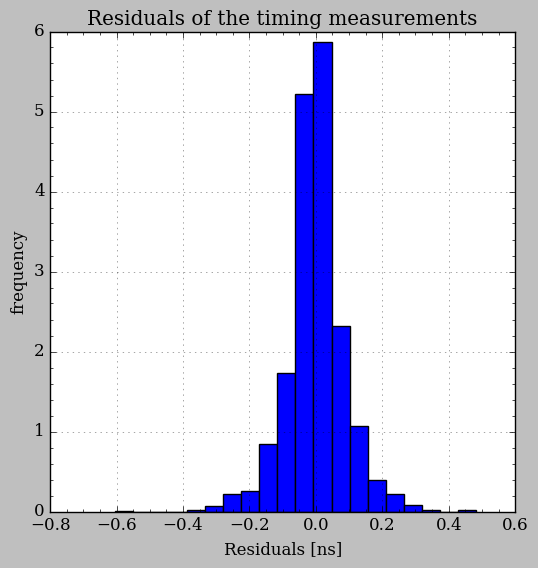

In [209]:
#plot the residuals in histogram
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(residuals, bins = 20, density = True)
ax.set_xlabel('Residuals [ns]')
ax.set_ylabel('frequency')
ax.set_title('Residuals of the timing measurements')